# Classifier of Iberian Languages

This project focuses on a natural language processing (NLP) task of discriminating between similar languages (DSL). It is the task of predicting the language variety in which a given text was written.

From the machine-learning (ML) perspective, this task can be viewed as a multiclass, single-label classification problem, where automatic methods have to assign class labels to objects (text samples). The practical application of this task varies from information retrieval systems to machine translation and forensics.

The main objective of this project is to create a model for discrimination between indigenous languages currently spoken in the Iberian Peninsula. Moreover, the model should be efficient for practical deployment as an API service.

# Initialization
Loading necessary modules, notebook configuration and setting output styles.

In [2]:
# Data processing & analysis
import numpy as np 
import pandas as pd 
import scipy
import re
from collections import Counter
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive visualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
    ) 
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Explaining the predictions of classifier
from lime.lime_text import LimeTextExplainer

# Serialization / de-serialization
import dill

In [3]:
# Notebook configuration
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [4]:
# Setting styles
pd.set_option('display.max_colwidth', None)
sns.set_style('white')

# Corpus
The corpus contains random sentences from Wikipedia in seven languages, six of them are the Romance languages of the Indo-European language family: Asturian, Aragonese, Catalan, Galician, Portuguese and Spanish, and one is language isolate - Basque (Euskara).

The corpus includes only the sentences with a minimum size of 50 characters and a maximum of 500 characters. The corpus is balanced concerning the number of sentences per language.

In [5]:
# Loading data source as DataFrame
iberian_wiki = 'iberian_wiki.csv.gz' 
df = pd.read_csv(iberian_wiki)
df

,text,target
0,"De 1945 a 1950, un movimiento independentista conocido como Maasina Ruru organizó campañas de desobediencia civil y de huelgas en las islas, en particular en la isla de Malaita.",es
1,"El coro es una de las estancias más valiosas de la Catedral de Málaga, obra cumbre de la carpinteria barroca y uno de los más deslumbrantes trabajos del escultor Pedro de Mena.",es
2,"El hecho resultaba condenable para la moral de aquellos años, pero también indica una actitud poco conservadora por parte de sus padres y sobre todo por parte de su madre, a pesar de que pocos años antes había estado a punto de convertirse en monja.",es
3,Actualmente se le esta investigando por el posible uso de sustancias para mejorar su rendimiento durante su carrera en las Grandes Ligas.,es
4,"Luego del 17 de octubre Perón comenzó su campaña electoral como candidato del Partido Laborista, llevando como vicepresidente a Hortensio Quijano, un radical de la disidente Junta Renovadora.",es
...,...,...
489995,"Alcheria (en arabe y alfabeto arabe الجزائر, al-Jazàïr ) ye un país d'Africa, en o Maghreb, en o norte d'Africa.",arg
489996,"Villacañas ye un municipio d'a provincia de Toledo, en a comunidat autonoma de Castiella-La Mancha, Espanya.",arg
489997,Iste instrumento amenista un diseño elaborato ta que lo suyo emplego siga eficient.,arg
489998,"Entre atros actors, partecipan en a cinta Clark Gable, Vivien Leigh, Leslie Howard, Olivia de Havilland, Hattie McDaniel, Butterfly McQueen, Thomas Mitchell y Barbara O'Neil; y a cinta recibió quantos premios, estando encara hue considerata como una d'as prencipals cintas d'a historia d'o cine.",arg


In [6]:
def preprocess(text):
    '''
    Text cleaning.
    
    Converts text to lower case 
    and substitutes punctuation, symbols and digits with spaces.
    
    Parameters: 
    text (str): Natural text
    
    Returns:
    preprocessed_text (str): cleaned lowercased text
    '''
    punct = '“”«»°º…¿¡¨²!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~\n—–‘·’´\t•―-'
    digits = '0123456789'
    stop_chars = punct+digits
    preprocessed_text = text.lower()
    translation_table = str.maketrans(stop_chars, ' '*len(stop_chars))
    preprocessed_text = preprocessed_text.translate(translation_table)
    
    return preprocessed_text


# Creating new column with cleaned text
df['clean'] = df['text'].apply(preprocess)
df

,text,target,clean
0,"De 1945 a 1950, un movimiento independentista conocido como Maasina Ruru organizó campañas de desobediencia civil y de huelgas en las islas, en particular en la isla de Malaita.",es,de a un movimiento independentista conocido como maasina ruru organizó campañas de desobediencia civil y de huelgas en las islas en particular en la isla de malaita
1,"El coro es una de las estancias más valiosas de la Catedral de Málaga, obra cumbre de la carpinteria barroca y uno de los más deslumbrantes trabajos del escultor Pedro de Mena.",es,el coro es una de las estancias más valiosas de la catedral de málaga obra cumbre de la carpinteria barroca y uno de los más deslumbrantes trabajos del escultor pedro de mena
2,"El hecho resultaba condenable para la moral de aquellos años, pero también indica una actitud poco conservadora por parte de sus padres y sobre todo por parte de su madre, a pesar de que pocos años antes había estado a punto de convertirse en monja.",es,el hecho resultaba condenable para la moral de aquellos años pero también indica una actitud poco conservadora por parte de sus padres y sobre todo por parte de su madre a pesar de que pocos años antes había estado a punto de convertirse en monja
3,Actualmente se le esta investigando por el posible uso de sustancias para mejorar su rendimiento durante su carrera en las Grandes Ligas.,es,actualmente se le esta investigando por el posible uso de sustancias para mejorar su rendimiento durante su carrera en las grandes ligas
4,"Luego del 17 de octubre Perón comenzó su campaña electoral como candidato del Partido Laborista, llevando como vicepresidente a Hortensio Quijano, un radical de la disidente Junta Renovadora.",es,luego del de octubre perón comenzó su campaña electoral como candidato del partido laborista llevando como vicepresidente a hortensio quijano un radical de la disidente junta renovadora
...,...,...,...
489995,"Alcheria (en arabe y alfabeto arabe الجزائر, al-Jazàïr ) ye un país d'Africa, en o Maghreb, en o norte d'Africa.",arg,alcheria en arabe y alfabeto arabe الجزائر al jazàïr ye un país d africa en o maghreb en o norte d africa
489996,"Villacañas ye un municipio d'a provincia de Toledo, en a comunidat autonoma de Castiella-La Mancha, Espanya.",arg,villacañas ye un municipio d a provincia de toledo en a comunidat autonoma de castiella la mancha espanya
489997,Iste instrumento amenista un diseño elaborato ta que lo suyo emplego siga eficient.,arg,iste instrumento amenista un diseño elaborato ta que lo suyo emplego siga eficient
489998,"Entre atros actors, partecipan en a cinta Clark Gable, Vivien Leigh, Leslie Howard, Olivia de Havilland, Hattie McDaniel, Butterfly McQueen, Thomas Mitchell y Barbara O'Neil; y a cinta recibió quantos premios, estando encara hue considerata como una d'as prencipals cintas d'a historia d'o cine.",arg,entre atros actors partecipan en a cinta clark gable vivien leigh leslie howard olivia de havilland hattie mcdaniel butterfly mcqueen thomas mitchell y barbara o neil y a cinta recibió quantos premios estando encara hue considerata como una d as prencipals cintas d a historia d o cine


In [78]:
def get_stats(df):
    '''
    Gets corpus statistics.  
    
    Statistics include: number of languages, sentences,
    words and unique words.
        
    Parameters: 
    df (DataFrame): Corpus
    
    Returns:
    stats (DataFrame): Statistical information
    '''
    d, total = [], []
    # Row per language
    for lang in df['target'].unique():
        temp = df[df['target'] == lang]
        text = temp['text'].to_list()
        words = ' '.join(text).split()
        unique = ' '.join(temp['clean'].to_list()).split()
        d.append(
            {
                'Language': lang, 'Number of sentences': len(text),
                'Number of words': len(words),
                'Number of unique words': len(set(unique))
                }
                )
    stats = pd.DataFrame(d)
    stats = stats.sort_values(by=['Number of words'], ascending=False)
    # Row with total values 
    total = {
        'Language': len(df['target'].unique()),
        'Number of sentences': stats['Number of sentences'].sum(),
        'Number of words': stats['Number of words'].sum(),
        'Number of unique words': len(
            set(' '.join(df['clean'].to_list()).split())
            )
            }
    stats = stats.append(total, ignore_index=True).reset_index(drop=True)
    ind = stats.index.tolist()
    ind[len(ind)-1] = 'Total'
    stats.index = ind

    return stats

# Statistics of the dataset
stats = get_stats(df)
# Styling values for readability
stats.style.format('{:,}', subset=[
    'Number of sentences', 'Number of words', 'Number of unique words'
    ]
    )

,Language,Number of sentences,Number of words,Number of unique words
0,es,"70,000","1,867,851","107,627"
1,arg,"70,000","1,783,171","100,003"
2,ca,"70,000","1,781,437","106,548"
3,pt,"70,000","1,701,187","98,353"
4,gl,"70,000","1,669,051","109,741"
5,ast,"70,000","1,647,162","112,278"
6,eu,"70,000","1,195,251","116,247"
Total,7,"490,000","11,645,110","512,548"


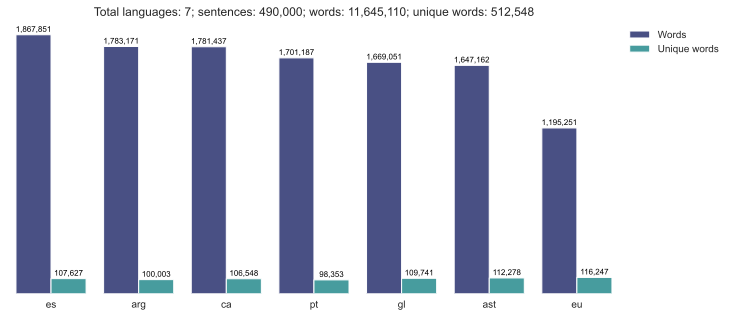

In [62]:
def stats_vis(df):
    '''
    Visualization of corpus statistics.
    
    Plots bar chart showing number of words and unique words per language.
    
    Parameters: 
    df (DataFrame): Statistical information
    
    Returns:
    None
    '''
    tot_l = df.loc['Total']['Language']
    tot_s = df.loc['Total']['Number of sentences']
    tot_w = df.loc['Total']['Number of words']
    tot_u = df.loc['Total']['Number of unique words']

    viz = df.copy()
    viz.rename(columns={
        'Number of words': 'Words',
        'Number of unique words': 'Unique words'
        },
        inplace=True
        )
    viz.drop('Total', inplace=True)
    # Unpivoting DataFrame from wide to long format
    viz = viz.melt(id_vars=['Language'], value_vars=['Words', 'Unique words'])
    # Plotting bar chart
    plt.figure(figsize=(11, 5))
    ax = sns.barplot(
        x='Language', y='value', hue='variable', data=viz, palette='mako'
        )
    ax.legend(bbox_to_anchor=(1, 1), loc=2, frameon=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([], [])
    # Plotting values over each bar
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), ',.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', size=8, color='black',
            xytext=(0, 5), textcoords='offset points'
            )
    plt.title(
        f'Total languages: {tot_l}; sentences: {tot_s:,}; words: {tot_w:,}; unique words: {tot_u:,}',
        fontsize=12
        )
    sns.despine(left=True, bottom=True)
    
    # Uncomment to save picture
    # plt.savefig("stats.png", bbox_inches='tight', dpi=300)
    
    plt.show()

# Visualizing statistics of the dataset
stats_vis(stats)

# Baseline Model
The baseline model uses conventional BOW method, where each feature corresponds to a single word found
in the training corpus. Thus, all the words occurring in the corpus contribute to the feature set.

In [9]:
# Baseline model
X = df['clean']
y = df['target']
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=0.2, random_state=1
    )
# Making pipeline for the baseline model
base_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('clf', LinearSVC(max_iter=10000))
        ]
        )
# Fitting the baseline pipe
base_pipe.fit(X_train_base, y_train_base)
# Getting predictions and printing classification report
predictions_base = base_pipe.predict(X_test_base)
print(classification_report(y_test_base, predictions_base, digits=4))

              precision    recall  f1-score   support

         arg     0.9939    0.9876    0.9908     13898
         ast     0.9885    0.9822    0.9853     13952
          ca     0.9971    0.9949    0.9960     14030
          es     0.9740    0.9890    0.9814     14031
          eu     0.9972    0.9973    0.9972     14044
          gl     0.9809    0.9859    0.9834     14097
          pt     0.9929    0.9871    0.9900     13948

    accuracy                         0.9891     98000
   macro avg     0.9892    0.9891    0.9892     98000
weighted avg     0.9892    0.9891    0.9892     98000



In [10]:
def get_pipe_info(
        pipeline, pipeline_name, pipeline_y_test, pipeline_predictions
        ):
    '''
    Evaluation of a pipeline. 
    
    Builds DataFrame containing name, accuracy score, 
    number of features and file size.
    
    Parameters: 
    pipeline (Pipeline): sklearn Pipeline 
    pipeline_name (str): Name for pipeline
    pipeline_y_test (array): y_test of used X_test 
    pipeline_predictions (array): predictions of pipeline
    
    Returns:
    df (DataFrame): Evaluation metrics in one row
    '''
    # Dictionary with evaluation metrics
    pipe_dict = {
        pipeline_name: [
            # Accuracy is used because classes are balanced
            round(accuracy_score(pipeline_y_test, pipeline_predictions), 6),
            len(pipeline.named_steps['vect'].get_feature_names()),
            len(dill.dumps(pipeline))
            ]
            }
    # Building dataframe from dictionary
    df = pd.DataFrame.from_dict(
        pipe_dict, orient='index',
        columns=[
            'Accuracy',
            'Number of features',
            'File size'
            ]
            )
    
    return df

In [32]:
# Evaluation metrics for the Baseline model
base_info = get_pipe_info(base_pipe, 'Baseline', y_test_base, predictions_base)
# Styling values for readability
base_info.style.format('{:,}')

,Accuracy,Number of features,File size
Baseline,0.989143,"454,358","32,913,443"


# Exploratory Data Analysis
Exploratory data analysis was conducted to study the distribution of character bigrams and words in each language.

In [12]:
def get_freqs(df):
    '''
    Counts frequencies of words and character bigrams per language.
        
    Parameters:
    df (DataFrame): Corpus
    
    Returns:
    frequencies (dict) : words and character bigrams with frequencies
        sorted by their frequency per language
    '''
    frequencies = {}
    # Iterating languages
    for lang in df['target'].unique():
        text = ' '.join(df[df['target'] == lang]['clean'].to_list())
        word_freq = Counter(text.split())
        sorted_word_freq = sorted(
            word_freq.items(), key=lambda x: x[1], reverse=True
            )
        bigram_freq = dict(Counter(map(''.join, zip(text, text[1:]))))
        # Filtering out bigrams with spaces and abnormal representation
        filtered_bigram_freq = {
            key: value for (key, value) in bigram_freq.items()
            if (' ' not in key) and (len(repr(key)) == 4)
            }
        sorted_bigram_freq = sorted(
            filtered_bigram_freq.items(), key=lambda x: x[1], reverse=True
            )
        # Dictionary per language
        frequencies[lang] = {
            'words': sorted_word_freq, 'bigrams': sorted_bigram_freq
            }

    return frequencies


# Counting frequencies of words and character level bi-grams per language
frequencies = get_freqs(df)

In [13]:
# Dictionary of the full names of the languages
lang_dict = {
    'es': 'Spanish',
    'pt': 'Portuguese',
    'ca': 'Catalan',
    'eu': 'Basque',
    'gl': 'Galician',
    'ast': 'Asturian',
    'arg': 'Aragonese'
    }

In [63]:
def explore(lang, top, frequencies=frequencies):
    '''
    Plots interactive visualisation of top words and character bigrams
    for a given language.
    
    Parameters:
    lang (str): language code
    top (int): number of top words and character bigrams
    frequencies (dict): dictionary with words, character bigrams 
        and their frequencies per language
        
    Returns:
    None
    '''
    words, freq_w = zip(*frequencies[lang]['words'][:top])
    bigrams, freq_b = zip(*frequencies[lang]['bigrams'][:top])
    
    fig = make_subplots(rows=2, shared_xaxes=False, shared_yaxes=False)
    fig.add_trace(go.Scatter(
        x=bigrams, y=freq_b, mode='lines+markers', name='count'), row=1, col=1
        )
    fig.add_trace(go.Scatter(
        x=words, y=freq_w, mode='lines+markers', name='count'), row=2, col=1
        )
    y_a = dict(title='Counts', fixedrange=True)
    fig.update_layout(
        title=(
            f'Counts for top {top} character bigrams and words in {lang_dict[lang]} language'
            ),
        showlegend=False, plot_bgcolor='white', dragmode='pan', hovermode='x',
        xaxis=dict(range=[-1, 50], title='Bi-grams'),
        xaxis2=dict(range=[-1, 50], title='Words'),
        yaxis=y_a,
        yaxis2=y_a
        )

    fig.show()

In [64]:
# Exploring frequencies of words and character level bi-grams per language
explore('es', 500)

In [65]:
def get_zipf(frequencies):
    '''
    Calculates expected counts (frequencies) for words and character bigrams
    according to Zipf's Law. Index values are ranks in the corpus.
    
    Parameters:
    frequencies (dict): dictionary of dictionaries of words, character bigrams 
        and their frequencies per language
    
    Returns:
    zipf (dict): dictionary of DataFrames of features per language
    '''
    zipf = {}
    # Itirating languages
    for lang in frequencies.keys():
        zipf.update({lang: {}})
        # Itirating types of features
        for level in frequencies[lang].keys():
            temp = pd.DataFrame(
                frequencies[lang][level], columns=[level, 'count']
                )
            temp.index = temp.index + 1
            total = temp['count'].sum()
            # Calculating expected counts
            # Counts of words in language are int
            temp['expected_count'] = np.round(
                temp['count'].max() * (1 / temp.index)
                )
            # Count can't be 0
            temp['expected_count'] = temp['expected_count'].apply(
                lambda x: 1 if x == 0 else x
                )
            zipf[lang][level] = temp

    return zipf

In [66]:
# Calculating expected counts according to Zipf's Law
zipf = get_zipf(frequencies)

In [74]:
def chi(df):
    '''
    Calculates a one-way chi-square test.
    
    Tests the null hypothesis that the categorical data has the given frequencies.
    
    Parameters:
    df (DataFrame): Contains observed frequencies and expected frequencies
    
    Returns:
    p_value (float): p-value of the test
    '''
    actual_count = df['count']
    expected_count = df['expected_count']
    _, p_value = scipy.stats.chisquare(actual_count, expected_count)
    return p_value


def zipf_vis(lang):
    '''
    ZIpf's Law visualization.
    
    Interactive visualization of character bigram and word 
    counts (frequencies) and ranks in the Corpus. 
    Performs chi-square test of observed and theoretical frequencies.
        
    Parameters:
    lang (str): Language code
    
    Returns:
    None
    '''
    p_value_b = chi(
        zipf[lang]['bigrams'][['count', 'expected_count']].query(
            'expected_count > 5 and count > 5'
            )
            )
    p_value_w = chi(
        zipf[lang]['words'][['count', 'expected_count']].query(
            'expected_count > 5 and count > 5'
            )
            )
    # Test results
    chi_text = f'X<sup>2</sup> test<br>Bigrams p-value < 0.05: {"yes" if p_value_b < 5/100 else "no"}<br>Words p-value < 0.05: {"yes" if p_value_w < 5/100 else "no"}'
    # Getting data to plot
    bigrams = zipf[lang]['bigrams'].index.values
    freq_b = zipf[lang]['bigrams']['count']
    freq_b_t = zipf[lang]['bigrams']['expected_count']
    words = zipf[lang]['words'].index.values
    freq_w = zipf[lang]['words']['count']
    freq_w_t = zipf[lang]['words']['expected_count']
    words_1_c = zipf[lang]['words'][zipf[lang]['words']['words'].str.len()==1].index.values
    freq_w_1_c = zipf[lang]['words'][zipf[lang]['words']['words'].str.len()==1]['count']
    words_3_c = zipf[lang]['words'][zipf[lang]['words']['words'].str.len()==3].index.values
    freq_w_3_c = zipf[lang]['words'][zipf[lang]['words']['words'].str.len()==3]['count']
    # Plotting 
    fig = make_subplots(cols=2, shared_xaxes=False, shared_yaxes=False)
    # Theoretical data
    fig.add_trace(go.Scatter(
        x=bigrams, y=freq_b_t, mode='markers', name='Theoretical bigrams',
        marker=dict(color='lightpink', symbol='diamond')),
        row=1, col=1
        )
    fig.add_trace(go.Scatter(
        x=words, y=freq_w_t, mode='markers', name='Theoretical words',
        marker=dict(color='lightpink', symbol='diamond')),
        row=1, col=2
        )
    # Empirical data
    fig.add_trace(go.Scatter(
        x=bigrams, y=freq_b, mode='markers', name='Empirical bigrams',
        marker=dict(color='lightskyblue')),
        row=1, col=1
        )
    fig.add_trace(go.Scatter(
        x=words, y=freq_w, mode='markers', name='Empirical words',
        marker=dict(color='lightskyblue')),
        row=1, col=2
        )
    fig.add_trace(go.Scatter(
        x=words_3_c, y=freq_w_3_c, mode='markers', name='3 characters words',
        marker=dict(color='blue'), visible='legendonly'),
        row=1, col=2
        )
    fig.add_trace(go.Scatter(
        x=words_1_c, y=freq_w_1_c, mode='markers', name='1 character words',
        marker=dict(color='red'), visible='legendonly'),
        row=1, col=2
        )
    fig.update_layout(
        title=(f"Zipf's Law for character bigrams and words in {lang_dict[lang]} language"),
        plot_bgcolor='white',
        xaxis=dict(title='rank of bigram', type="log"),
        xaxis2=dict(title='rank of word', type="log"),
        yaxis=dict(title='count of bigram', type="log"),
        yaxis2=dict(title='count of word', type="log"),
        legend=dict(
            orientation="h", yanchor='bottom', y=1, xanchor='right', x=1
            ),
        annotations=[
            go.layout.Annotation(
                text=chi_text, align='right', showarrow=False,
                xref='paper', yref='paper', x=1, y=1
                )
                ]
                )
    
    # Uncomment to save figure
    # fig.write_image("zipf.png", width=1088, height=525)
    
    fig.show()

In [76]:
# Plotting this could slow down computer.
zipf_vis('es')

# Feature set
In order to reduce the dimensionality of the feature space and the memory requirements, the feature set consists of the most frequent in each language character bigrams and 1, 3 characters words that were selected from the most frequent words in each language.

In [14]:
def build_vocab(frequencies, b=400, w=400):
    '''
    Builds feature set.
    
    Uses the most frequent character bigrams and 1, 3 characters words selected 
    from top words in each language. Filters out stop words and bigrams.
    
    Parameters:
    frequencies (dict): Dictionary with frequencies
    b (int): Number of top character bigrams 
    w (int): Number of top words
    
    Returns:
    df (DataFrame): Feature set 
    '''
    # Stop words and character bigrams
    stop_w = ['etc', 'iii', 'm', 'v', 'x', 'xix', 'xvi', 'the', 'c', 'top']
    stop_b = ['kg', 'km', 'mm', 'xx']
    
    df = pd.DataFrame()
    features, language, level = [], [], []
    # Iterating languages
    for lang in frequencies.keys():
        words = frequencies[lang]['words'][:w]
        # Including only 1 or 3 character words
        words = [k for k, v in words if len(k) == 1 or len(k) == 3]
        # Filtering out stop words
        words = [word for word in words if word not in stop_w]
        bigrams, _ = zip(*frequencies[lang]['bigrams'])
        # Filtering out stop bigrams
        bigrams = [bigram for bigram in bigrams if bigram not in stop_b][:b]
        features.extend(bigrams)
        features.extend(words)
        language.extend([lang] * (b+len(words)))
        level.extend(['bigram'] * b)
        level.extend(['word'] * len(words))
    # Building DataFrame
    df['feature'] = features
    df['language'] = language
    df['level'] = level
    # Grouping same features that are present in several languages
    df = df.groupby('feature').agg(
        {
            'language': lambda x: ', '.join(sorted(set(x))),
            'level': 'first'
            }
            )
    df = df.reset_index()

    return df

# Bulding feature set
vocab = build_vocab(frequencies)

In [70]:
def vocab_vis(kind, vocab=vocab):
    '''
    Visualization of feature set with Plotly.
    
    Plots interactive visualization of feature set.
    Three kinds available: 
        overview - simple pie chart,
        sun - detailed sunburst diagram,
        tree - detailed tree diagram, wider view.
        
    Parameters:
    kind (str): kind of visualization of feature set
    vocab (DataFrame): Feature set
    
    Returns:
    None
    '''
    vis_path = [
                'vocabulary', 'language', 'level', 'feature'
                ],
    vis = vocab.copy()
    vis['vocabulary'] = 'Feature Set'
    # Simple overview 
    if kind == 'overview':
        fig = px.pie(
            vis, names='level',
            title=f'Total number of features: {vis.shape[0]}',
            color_discrete_sequence=['darkblue', 'royalblue'],
            )
        fig.update_traces(
            textposition='inside', textinfo='percent+label+value'
            )
        fig.update_layout(showlegend=False)
    # Interactive sunburst diagram
    if kind == 'sun':
        fig = px.sunburst(
            vis,
            path=vis_path,
            maxdepth=2
            )
        fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
    # Interactive tree diagram
    if kind == 'tree':
        fig = px.treemap(
            vis,
            path=vis_path,
            maxdepth=3
            )
        fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))

    fig.show()

In [71]:
# Interactive visualization of the feature set
# Parameters: overview, sun, tree
vocab_vis('overview')

In [15]:
# Separating character bigram and word features for processing
vocab_b = vocab.loc[vocab['level'] == 'bigram', 'feature'].to_list()
vocab_w = vocab.loc[vocab['level'] == 'word', 'feature'].to_list()

In [16]:
def process(text, vocab_w=vocab_w, vocab_b=vocab_b):
    '''
    Processing cleaned text.
    
    Checks every word in input text.
    Leaves only words that are in the feature set.
    Splits other words into character bigrams
    and leaves only bigrams that are in the feature set.
    
    Parameters:
    text (str): cleaned text
    vocab_w (list): word features
    vocab_b (list): character bigram features
    
    Returns:
    output (str): Processed text
    '''
    output = []
    for word in text.split():
        if word in vocab_w:
            output.append(word)
        else:
            for bigram in list(map(''.join, zip(word, word[1:]))):
                if bigram in vocab_b:
                    output.append(bigram)
    
    output = ' '.join(output)
    
    return output

In [17]:
# Processing cleaned text
df['processed'] = df['clean'].apply(process)
# Splitting the dataset into train and test sets
X = df['processed']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
    )

# Model
As a machine-learning algorithm, Linear Support Vector Classification (sklearn.svm.LinearSVC) was selected for the model. LinearSVC is implemented in terms of liblinear and the multiclass support is handled according to a one-vs-the-rest scheme.

In [ ]:
# Grid search to find the best regularization parameter "C"
# Custom token pattern to include one character words
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
# Parameter range
param_grid = {
    'C': [0.01, 0.1, 1],
    }
# Grid definition
grid = GridSearchCV(
    LinearSVC(), param_grid, refit=True, n_jobs=-1
    )
# Fitting the model for grid search
grid.fit(X_train_vect, y_train)
grid_predictions = grid.predict(X_test_vect)
best_params = grid.best_params_
# Printing classification report & best parameter
print(classification_report(y_test, grid_predictions))
print(grid.best_params_)

In [18]:
# Using the best parameter for the model
model = LinearSVC(C=0.1, max_iter=10000)
# CalibratedClassifierCV allows to add probability output to LinearSVC
# predict_proba will be used for Lime Explainer and plotting of ROC AUC
clf = CalibratedClassifierCV(model, method='sigmoid', cv=3)
# Creating pipeline
# Custom token pattern to include one character words
pipe = Pipeline(
    [
        ('vect', CountVectorizer(token_pattern=r'(?u)\b\w+\b')),
        ('clf', clf)
        ]
        )
# Fitting the pipeline
pipe.fit(X_train, y_train)
# Getting predictions and printing classification report
predictions = pipe.predict(X_test)
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         arg     0.9707    0.9656    0.9681     13898
         ast     0.9728    0.9498    0.9612     13952
          ca     0.9933    0.9867    0.9900     14030
          es     0.9364    0.9668    0.9513     14031
          eu     0.9946    0.9968    0.9957     14044
          gl     0.9591    0.9720    0.9655     14097
          pt     0.9839    0.9712    0.9775     13948

    accuracy                         0.9727     98000
   macro avg     0.9730    0.9727    0.9728     98000
weighted avg     0.9730    0.9727    0.9728     98000



In [34]:
# Evaluation metrics for the model
pipe_info = get_pipe_info(pipe, 'Pipe', y_test, predictions)
pipe_info.style.format('{:,}')

,Accuracy,Number of features,File size
Pipe,0.972735,847,"153,761"


# Comparison with the baseline model

In [35]:
compare = pd.concat([base_info, pipe_info])
compare.style.format('{:,}')

,Accuracy,Number of features,File size
Baseline,0.989143,"454,358","32,913,443"
Pipe,0.972735,847,"153,761"


In [38]:
# Percentage change
compare.pct_change().style.format("{:.2%}")

,Accuracy,Number of features,File size
Baseline,nan%,nan%,nan%
Pipe,-1.66%,-99.81%,-99.53%


In comparison with the baseline model, considerable reduction of the feature space (-99.81%) and thus reduction of the memory requirements (-99.53%) were achieved with only a small decrease in the accuracy (-1.66%). 

# Visualization of evaluation metrics
Confusion Matrix is visualized with Seaborn.
Interactive ROC AUC graph is made with Plotly.

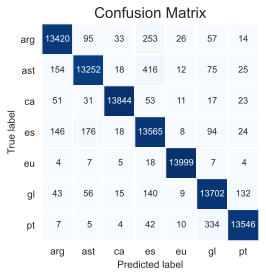

In [20]:
# Visualizing Confusion Matrix 
classes = pipe.classes_
cm = confusion_matrix(y_test, predictions)
ax = sns.heatmap(
    cm, annot=True, annot_kws={"size": 9}, fmt='2.0f', linewidths=1,
    cmap='Blues', yticklabels=classes, xticklabels=classes, cbar=False,
    mask=cm == 0, # Masking zero values
    square=True
    )
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted label', fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.yticks(rotation=0)

# Uncomment to save figure
# plt.savefig("conf_matrix.png", bbox_inches='tight', dpi=300)

plt.show()

In [28]:
# Interactive visualization of ROC AUC
y_scores = pipe.predict_proba(X_test)
# One hot encode the labels in order to plot them
y_onehot = pd.get_dummies(y_test, columns=classes)
fig = go.Figure()
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
# Iteratively adding new line for each class
for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    name = f"{y_onehot.columns[i]} (AUC={auc_score:.6f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))
fig.update_layout(
    title=dict(text='ROC AUC', y=0.9, x=0.5, xanchor='center', yanchor='top'),
    xaxis_title='False Positive Rate', yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1), xaxis=dict(constrain='domain'),
    template='plotly_white' # Setting plotly style
    )
fig.show()

# Explaining the predictions of the classifier
Lime package (local interpretable model-agnostic explanations) is used for the explanation. 

In [21]:
# Lime Explainer
explainer = LimeTextExplainer(class_names=classes)

In [82]:
# Explaining random sentence from test set
idx = random.choice(X_test.index)
sample = X_test[idx]
print(f'Language:{y_test[idx]} \nSample: {df["text"][idx]}')
exp = explainer.explain_instance(
    process(preprocess(sample)),
    pipe.predict_proba,
    num_features=10, top_labels=2
    )
# Displaying explanation in notebook
exp.show_in_notebook(text=True)

Language:ca 
Sample: Per aquests sabem que els ibers estaven dividits en tribus i pobles que hom a pretès de situar en unes regions determinades, però amb fronteres poc precises.


# Model persistence
Dill module is used for serializing and de-serializing of the pipeline.

In [26]:
def save(objct, file_name):
    '''
    Saving object with dill
    
    Parameters:
    objct (Object): Object to save
    file_name (str): File name for object
    
    Returns:
    None
    '''
    with open(file_name, 'wb') as io:
        dill.dump(objct, io)

        
def load(file_name):
    '''
    Loading object with dill
    
    Parameters:
    file_name (str): Object file name
    
    Returns:
    objct (Object) : De-serialized object
    '''
    with open(file_name,'rb') as io:
        objct = dill.load(io)
    
    return objct

In [27]:
# Saving pipeline with dill
save(pipe, 'pipe.joblib')